<h3> Bounding Boxes </h3>

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import numpy as np

In [2]:
files_in_dir = os.listdir()
dogcatimg = os.path.join(os.getcwd(),files_in_dir[1])
dogcatimg

'c:\\Users\\ASUS\\Desktop\\Hands on ML\\Hands-on-Machine-Learning-Textbook-Exercises\\DeepLearning_1\\Images\\dogcat.JPG'

In [3]:
dogcatimg_pixels = tf.io.decode_image(tf.io.read_file(dogcatimg))
#276,361,3

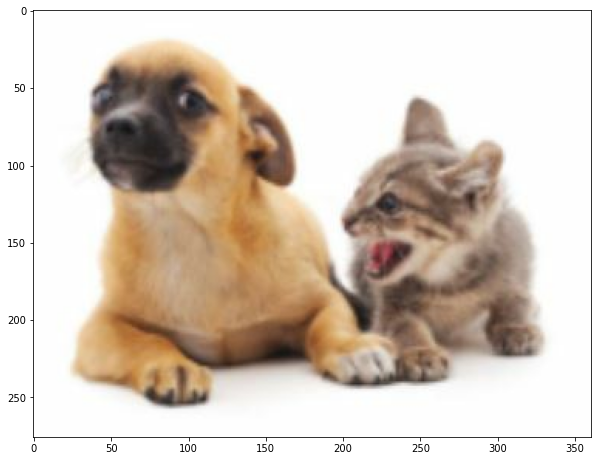

In [4]:
fig,ax = plt.subplots(1,1,figsize = (10,10))
ax.imshow(dogcatimg_pixels)

In [5]:
#upper_left, bottom_right
dog_box = [25.0,25.0,200.0,250.0]
cat_box = [200.0,50.0,330.0,225.0]

In [6]:
def box_corner_to_center(boxes):
    #upper_left
    x1 = boxes[0]
    y1 = boxes[1]
    #bottom_right
    x2 = boxes[2]
    y2 = boxes[3]
    centerx = (x1 + x2)/2
    centery = (y1 + y2)/2
    width = abs(x1 - x2)
    height = abs(y1 - y2)
    boxes = tf.stack((centerx,centery,width,height),axis = -1)
    return boxes

def box_center_to_corner(boxes):
    centerx = boxes[0]
    centery = boxes[1]
    width = boxes[2]
    height = boxes[3]
    #center to upper_left
    x1 = centerx - (width/2)
    y1 = centery - (height/2)
    #center to bottom_right
    x2 = centerx + width/2
    y2 = centery + (height/2)
    boxes = tf.stack((x1,y1,x2,y2),axis = -1)
    return boxes

In [7]:
boxes = tf.constant((dog_box,cat_box))
boxes

<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[ 25.,  25., 200., 250.],
       [200.,  50., 330., 225.]], dtype=float32)>

In [8]:
center = tf.map_fn(box_corner_to_center,elems = boxes)
corners = tf.map_fn(box_center_to_corner,elems = center)

In [9]:
def box_to_rect(box,color):
    return plt.Rectangle(xy = (box[0],box[1]),width = box[2]-box[0],
                         height = box[3] - box[1],fill = False, edgecolor = color,linewidth = 2)

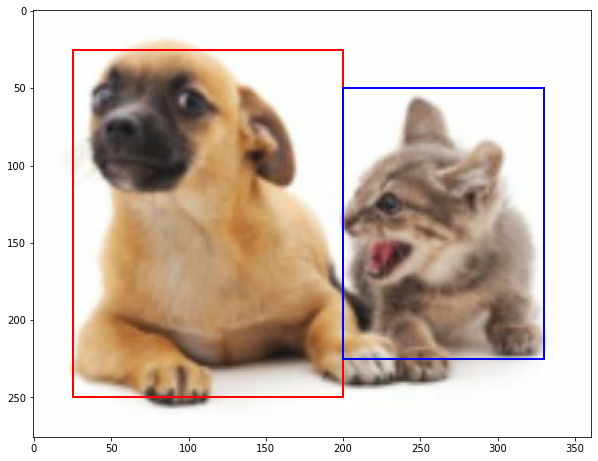

In [10]:
fig,ax = plt.subplots(1,1,figsize = (10,10))
ax.imshow(dogcatimg_pixels)
ax.add_patch(box_to_rect(dog_box,color = 'red'))
ax.add_patch(box_to_rect(cat_box,color = 'blue'))

<h3>Anchor Boxes</h3>

Object detection algorithms usually sample a large number of regions in an input image, determine whether these regions contain objects of interest and adjust the boundaries of the regions so as to predict the **ground truth bounding boxes** of the objects more accurately. 

There are different region sampling methods. Here we generate multiple bounding boxes with varying scales and aspect ratios centered on each pixel.

<h3>Generating multiple anchor boxes</h3>

Suppose the input image has a height of h and width of w. We generate anchor boxes with different shapes centered on each pixel. Scale (s) is between 0 to 1 and the aspect ratio(r)(ratio of width to height) is greater than 0. Width and height of the boxes are (ws(sqrt(r))) and (hs/(sqrt(r))). 

To generate multiple anchor boxes, we set up a series of scales s, and a series of aspect ratios r.

In [225]:
#generate multiple anchor boxes
def multibox_prior(data,sizes,ratios):
    #size and ratios are user specified
    in_height,in_width = data.shape[1],data.shape[2]
    devide,num_sizes,num_ratios = data.device,len(sizes),len(ratios)
    boxes_per_pixel = (num_sizes + num_ratios - 1)
    sizes_tensor = tf.identity(sizes)
    ratios_tensor = tf.identity(ratios)
    offset_h,offset_w = 0.5,0.5
    steps_h = 1.0/in_height
    steps_w = 1.0/in_width

    #generating centerpoints for anchor boxes
    centers_h = tf.identity((np.arange(in_height) + offset_h)) * steps_h
    centers_w = tf.identity((np.arange(in_width) + offset_w)) * steps_w
    #create a meshgrid of centers
    mesh_x,mesh_y = tf.meshgrid(centers_w,centers_h)
    shift_x,shift_y = tf.experimental.numpy.reshape(mesh_x,newshape=-1),tf.experimental.numpy.reshape(mesh_y,newshape=-1)
    w = tf.concat([sizes_tensor * tf.math.sqrt(ratios_tensor[0]),sizes[0]*tf.math.sqrt(ratios_tensor[1:])],axis = 0)*(in_height/in_width)
    h = tf.concat([sizes_tensor / tf.math.sqrt(ratios_tensor[0]),sizes_tensor[0]/tf.math.sqrt(ratios_tensor[1:])],axis = 0)
    #repeats each manipulation combination to height*width combination
    anchor_manipulations = tf.repeat(tf.transpose(tf.stack((-w,-h,w,h))),repeats = (in_height*in_width),axis = 0)/2
    
    #repeat the centers for the number of combinations of unique s and r (only s1,r1) (this repeats each block of center combinations for boxes_per_pixel times)
    out_grid = tf.cast(tf.tile(tf.stack([shift_x,shift_y,shift_x,shift_y],axis = 1),multiples = [boxes_per_pixel,1]),'float32')
    output = out_grid + anchor_manipulations
    #return with batch axis added to result
    return tf.expand_dims(output,axis = 0),anchor_manipulations

In [226]:
X = tf.random.uniform(shape=(1, 10, 10, 3)) 

In [227]:
Y,anchor_0 = multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1.0, 2.0, 0.5])

The resulting output Y is of shape (batch_size,number of anchor boxes, 4)

After changing it to shape (image_height, image_width,number_of_anchor_boxes,4)

In [228]:
anchor_boxes_per_pixel = tf.experimental.numpy.reshape(Y,newshape = (10,10,5,4))

In [229]:
#anchor boxes centered on the first pixel
list(enumerate(anchor_boxes_per_pixel[0,0,:,:]))[0][1].numpy()

array([-0.325, -0.325,  0.425,  0.425], dtype=float32)

In [230]:
def show_anchorboxes(axes,anchor_boxes,img,labels = None, colors = None):
    def make_list(obj,default = None):
        if obj == None:
            obj = default
        elif not isinstance(obj,(list,tuple)):
            obj = [obj]
        return obj
    
    labels = make_list(labels)
    colors = make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    axes.imshow(img)
    for i,anchor_bx in enumerate(anchor_boxes):
        color = colors[i%len(colors)]
        box = anchor_bx
        patch = plt.Rectangle(xy = (box[0],box[1]),width = box[2]-box[0],
        height = box[3] - box[1],fill = False, edgecolor = color,linewidth = 2)
        axes.add_patch(patch)
        


In [231]:
w,h,c = dogcatimg_pixels.shape

In [232]:
dogcatimg_pixels.shape

TensorShape([276, 361, 3])

In [233]:
scale = tf.cast(tf.identity((w,h,w,h)),'float32')
scale

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([276., 361., 276., 361.], dtype=float32)>

In [234]:
X = tf.random.uniform(shape=(1, w, h, 3)) 
Y,anchor = multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1.0, 2.0, 0.5])
Y.shape

TensorShape([1, 498180, 4])

In [235]:
anchor_boxes_per_pixel = tf.experimental.numpy.reshape(Y,newshape = (w,h,5,4))
anchor_boxes_per_pixel[0,0,:,:] * scale

<tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[ -78.74792 , -134.72101 ,   79.51246 ,  136.02899 ],
       [ -77.983376, -134.72101 ,   80.27701 ,  136.02899 ],
       [ -77.218834, -134.72101 ,   81.04154 ,  136.02899 ],
       [ -76.45429 , -134.72101 ,   81.80609 ,  136.02899 ],
       [ -75.68974 , -134.72101 ,   82.57064 ,  136.02899 ]],
      dtype=float32)>

In [241]:
test = Y*scale
temp = test.numpy()[0,[0,100,200,300,400],:]
temp

array([[ -78.74792 , -134.72101 ,   79.51246 ,  136.02899 ],
       [  -2.293623, -134.72101 ,  155.96677 ,  136.02899 ],
       [  74.160675, -134.72101 ,  232.42105 ,  136.02899 ],
       [ 150.61496 , -134.72101 ,  308.87534 ,  136.02899 ],
       [ -48.930748, -133.41304 ,  109.329636,  137.33696 ]],
      dtype=float32)

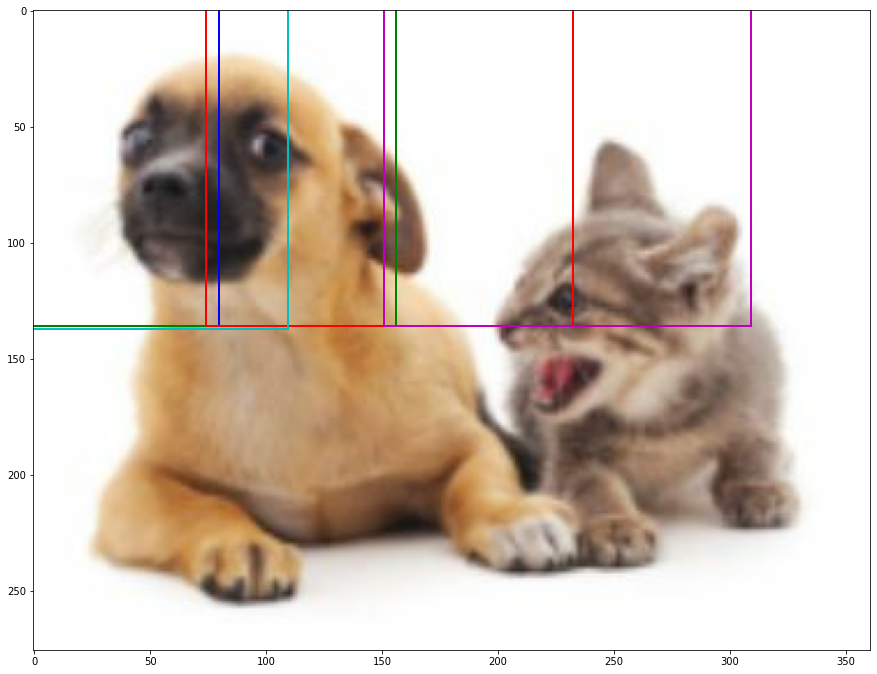

In [237]:
fig_anchor,ax_anchor = plt.subplots(1,1,figsize = (15,15))
show_anchorboxes(ax_anchor,temp,dogcatimg_pixels)

In [238]:
anchor

<tf.Tensor: shape=(498180, 4), dtype=float32, numpy=
array([[-0.2867036 , -0.375     ,  0.2867036 ,  0.375     ],
       [-0.2867036 , -0.375     ,  0.2867036 ,  0.375     ],
       [-0.2867036 , -0.375     ,  0.2867036 ,  0.375     ],
       ...,
       [-0.20273004, -0.5303301 ,  0.20273004,  0.5303301 ],
       [-0.20273004, -0.5303301 ,  0.20273004,  0.5303301 ],
       [-0.20273004, -0.5303301 ,  0.20273004,  0.5303301 ]],
      dtype=float32)>

In [239]:
2%5

2

In [240]:
X

<tf.Tensor: shape=(1, 276, 361, 3), dtype=float32, numpy=
array([[[[0.08669448, 0.9934256 , 0.44286644],
         [0.5243112 , 0.6396767 , 0.7608497 ],
         [0.17209685, 0.04584408, 0.7301645 ],
         ...,
         [0.65506375, 0.23849142, 0.6092496 ],
         [0.40097725, 0.37634242, 0.48925352],
         [0.42722225, 0.94591534, 0.07051098]],

        [[0.8394238 , 0.19486284, 0.25541282],
         [0.19380295, 0.73710215, 0.5010935 ],
         [0.27508128, 0.90168726, 0.8643855 ],
         ...,
         [0.14757037, 0.7763964 , 0.2094816 ],
         [0.696144  , 0.9388852 , 0.8542932 ],
         [0.13067472, 0.8055929 , 0.56923234]],

        [[0.96130395, 0.41966736, 0.75106263],
         [0.1166513 , 0.59799254, 0.4079125 ],
         [0.4813447 , 0.24600494, 0.51180196],
         ...,
         [0.9659574 , 0.6140096 , 0.67110085],
         [0.5019064 , 0.8476703 , 0.2955898 ],
         [0.0055784 , 0.7433616 , 0.36051857]],

        ...,

        [[0.5962627 , 0.645198  , 